## Set up the Data Processing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

from origami.preprocessing import (
    DocTokenizerPipe,
    KBinsDiscretizerPipe,
    PadTruncTokensPipe,
    SchemaParserPipe,
    SortFieldsPipe,
    TokenEncoderPipe,
    load_df_from_mongodb,
)
from origami.utils import set_seed

# For reproducibility
set_seed(123)


LIMIT = 4688354  # OnTime collection size
NUM_BINS = 32
STRATEGY = "kmeans"

FIELDS = [
    "ARR_DELAY",
    "DEST",
    "DEST_CITY_NAME",
    "FL_DATE",
    "MKT_UNIQUE_CARRIER",
    "OP_CARRIER_FL_NUM",
    "ORIGIN",
    "ORIGIN_CITY_NAME",
]

In [55]:
projection = {f: 1 for f in FIELDS} | {"_id": 0}

df = load_df_from_mongodb("mongodb://localhost:27017", "ontime", "ontime", projection=projection, limit=LIMIT)


# Create data pipeline (we don't use the build_prediction_pipelines() utility here because we need to set custom binning parameters)
pipeline = Pipeline(
    [
        ("binning", KBinsDiscretizerPipe(bins=NUM_BINS, strategy=STRATEGY)),
        ("sortfields", SortFieldsPipe()),
        ("schema", SchemaParserPipe()),
        # No upscaler or permuter, it's not needed for MC estimation
        ("tokenizer", DocTokenizerPipe()),
        ("padding", PadTruncTokensPipe(length="max")),
        ("encoder", TokenEncoderPipe()),
    ],
    verbose=True,
)

# Process data
processed_df = pipeline.fit_transform(df).reset_index(drop=True)

# Get stateful objects
schema = pipeline["schema"].schema
encoder = pipeline["encoder"].encoder
block_size = pipeline["padding"].length

# Print data stats
print(f"len train: {len(processed_df)}")
print(f"vocab size {encoder.vocab_size}")
print(f"block size {block_size}")

[Pipeline] ........... (step 1 of 6) Processing binning, total=22.9min
[Pipeline] ........ (step 2 of 6) Processing sortfields, total=  17.1s
[Pipeline] ............ (step 3 of 6) Processing schema, total= 1.2min
[Pipeline] ......... (step 4 of 6) Processing tokenizer, total= 3.8min
[Pipeline] ........... (step 5 of 6) Processing padding, total=  16.4s
[Pipeline] ........... (step 6 of 6) Processing encoder, total= 5.6min
len train: 4688354
vocab size 1193
block size 19


In [56]:
processed_df.head()

,docs,id,tokens
0,"{'ARR_DELAY': 29.13437684538166, 'DEST': 'CLT'...",0,"[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20..."
1,"{'ARR_DELAY': -17.822313824693722, 'DEST': 'BD...",1,"[1, 10, 26, 12, 27, 14, 28, 16, 29, 18, 19, 20..."
2,"{'ARR_DELAY': -9.021175904356323, 'DEST': 'BDL...",2,"[1, 10, 32, 12, 27, 14, 28, 16, 33, 18, 19, 20..."
3,"{'ARR_DELAY': -27.734899088394332, 'DEST': 'CL...",3,"[1, 10, 34, 12, 13, 14, 15, 16, 35, 18, 19, 20..."
4,"{'ARR_DELAY': -27.734899088394332, 'DEST': 'CL...",4,"[1, 10, 34, 12, 13, 14, 15, 16, 36, 18, 19, 20..."


## Train ORiGAMi Model

Here we instantiate an ORiGAMi model, a modified transformer trained on the token sequences created above.
We use a standard "medium" configuration. ORiGAMi models are relatively robust to the choice of hyper-parameter
and default configurations often work well for mid-sized datasets.

In [57]:
from origami.model import ORIGAMI
from origami.model.vpda import ObjectVPDA
from origami.preprocessing import DFDataset
from origami.utils import ModelConfig, TrainConfig, count_parameters

# Model and train configs
model_config = ModelConfig.from_preset("medium")  # "small" also works, see origami/utils/config.py for more presets
model_config.position_encoding = "KEY_VALUE"
model_config.vocab_size = encoder.vocab_size
model_config.block_size = block_size

train_config = TrainConfig()
train_config.learning_rate = 1e-4
train_config.print_every = 100

# Wrap dataframe in datasets
dataset = DFDataset(processed_df)

# Create PDA and pass it to the model
vpda = ObjectVPDA(encoder, schema)
model = ORIGAMI(model_config, train_config, vpda=vpda)

n_params = count_parameters(model)
print(f"Number of parameters: {n_params / 1e6:.2f}M")

Number of parameters: 3.13M


In [ ]:
from origami.utils import make_progress_callback

# Create and register progress callback
progress_callback = make_progress_callback(train_config, train_dataset=dataset)
model.set_callback("on_batch_end", progress_callback)
model.train_model(dataset, batches=50000)

|  step: 0  |  epoch: 0  |  batch_num: 0  |  batch_dt: 0.00  |  batch_loss: 3.6635  |  lr: 1.01e-07  |
|  step: 1  |  epoch: 0  |  batch_num: 100  |  batch_dt: 87.63  |  batch_loss: 3.0035  |  lr: 1.01e-05  |
|  step: 2  |  epoch: 0  |  batch_num: 200  |  batch_dt: 111.32  |  batch_loss: 2.1907  |  lr: 2.01e-05  |
|  step: 3  |  epoch: 0  |  batch_num: 300  |  batch_dt: 99.32  |  batch_loss: 2.0193  |  lr: 3.01e-05  |
|  step: 4  |  epoch: 0  |  batch_num: 400  |  batch_dt: 85.93  |  batch_loss: 1.9060  |  lr: 4.01e-05  |
|  step: 5  |  epoch: 0  |  batch_num: 500  |  batch_dt: 85.93  |  batch_loss: 1.6666  |  lr: 5.01e-05  |
|  step: 6  |  epoch: 0  |  batch_num: 600  |  batch_dt: 42.46  |  batch_loss: 1.5477  |  lr: 6.01e-05  |
|  step: 7  |  epoch: 0  |  batch_num: 700  |  batch_dt: 38.13  |  batch_loss: 1.3902  |  lr: 7.01e-05  |
|  step: 8  |  epoch: 0  |  batch_num: 800  |  batch_dt: 38.28  |  batch_loss: 1.3336  |  lr: 8.01e-05  |
|  step: 9  |  epoch: 0  |  batch_num: 900  |  b

In [ ]:
# Load/save model
# model.load("origami_ontime_full_checkpoint_50k.pt")
model.save("origami_ontime_full_checkpoint_50k.pt")

## Cardinality Estimation: MC vs Rejection Sampling

We'll compare two approaches for cardinality estimation:

1. **Monte Carlo (MC) Sampling**: Samples uniformly in the query region, weights by model probability
2. **Rejection Sampling**: Samples from model distribution, counts acceptance rate
3. **Dataset Sampling** (baseline): Run MongoDB query against a subset of the data


In [ ]:
from mdbrtools.estimator import SampleEstimator
from mdbrtools.mongodb import MongoCollection
from mdbrtools.workload import Workload

# create a sample estimator for the query workload
collection = MongoCollection("mongodb://localhost:27017/", "ontime", "ontime")
sample_est = SampleEstimator(collection, LIMIT, sample_ratio=0.01, persist=True)

NUM_QUERIES = 50

# create a new workload of random queries, passing in the estimator
workload = Workload()
workload.generate(
    collection,
    allowed_fields=FIELDS,
    estimator=sample_est,
    num_queries=NUM_QUERIES,
    limit=LIMIT,
    min_selectivity=0.0001,
    # max_selectivity=0.05,
    max_timeout_secs=3600,
    max_predicates=4,
)
workload.print()

Parsing schema: 100000it [00:02, 47926.66it/s]


100000 documents in collection. limit is 100000


Generating workload: 100%|██████████| 50/50 [00:00<00:00, 655.59it/s]

   0 Query(filter={'ORIGIN': {'$lte': 'BFM'}, 'DEST_CITY_NAME': 'Detroit, MI', 'ORIGIN_CITY_NAME': {'$in': ['Jackson/Vicksburg, MS', 'Orlando, FL', 'Newport News/Williamsburg, VA', 'Reno, NV', 'Gunnison, CO', 'Fresno, CA', 'Latrobe, PA', 'Minneapolis, MN', 'Austin, TX']}, 'ARR_DELAY': {'$lt': 65}})
   1 Query(filter={'MKT_UNIQUE_CARRIER': {'$gte': 'AA'}, 'ORIGIN': {'$in': ['MOB', 'ONT', 'LYH', 'TUS', 'DTW', 'OGG', 'TUL', 'TYR', 'ISP']}, 'DEST': {'$lte': 'FLL'}, 'ARR_DELAY': {'$lte': 498}})
   2 Query(filter={'ARR_DELAY': {'$lte': 428}, 'MKT_UNIQUE_CARRIER': {'$in': ['HA', 'OH', 'F9', 'AS', 'AA']}, 'DEST': {'$in': ['MIA', 'ABE', 'FAT', 'ROC', 'FWA']}, 'ORIGIN': {'$gte': 'GNV'}})
   3 Query(filter={'ARR_DELAY': {'$lte': -58}, 'OP_CARRIER_FL_NUM': {'$lte': 1638}})
   4 Query(filter={'MKT_UNIQUE_CARRIER': {'$lte': 'WN'}, 'OP_CARRIER_FL_NUM': {'$lte': 982}, 'ORIGIN_CITY_NAME': {'$gte': 'Cordova, AK'}})
   5 Query(filter={'ORIGIN': {'$lte': 'PIA'}, 'DEST': {'$gte': 'HDN'}, 'OP_CARRIER_FL_NUM

In [ ]:
import time

import numpy as np

# Create estimators
from origami.inference import MCEstimator, RejectionEstimator, Sampler

# MCEstimator
mc_est = MCEstimator(model, pipeline)

# RejectionEstimator
sampler = Sampler(model, encoder, schema)
rej_est = RejectionEstimator(sampler)

# Ground Truth
ground_truth = SampleEstimator(collection, LIMIT, 1.0)

estimators = [ground_truth, sample_est, mc_est, rej_est]

# store results
card_ests = np.zeros((len(workload), 4))
selectivities = np.zeros(len(workload))

# store timing results for each estimator
timing_results = {"ground_truth": [], "mongo_sample": [], "mc_est": [], "rej_est": []}

for i, query in enumerate(workload):
    # ground truth
    start_time = time.time()
    gt = int(ground_truth.estimate(query))
    timing_results["ground_truth"].append(time.time() - start_time)

    selectivity = gt / LIMIT
    selectivities[i] = selectivity

    # mongo estimator
    start_time = time.time()
    card_mongo = int(sample_est.estimate(query))
    timing_results["mongo_sample"].append(time.time() - start_time)

    # mc estimator
    start_time = time.time()
    p, s = mc_est.estimate(query, n=1000)
    timing_results["mc_est"].append(time.time() - start_time)
    card_mc = int(p * LIMIT)

    # rejection estimator
    start_time = time.time()
    p, s = rej_est.estimate(query, n=1000)
    timing_results["rej_est"].append(time.time() - start_time)
    card_rej = int(p * LIMIT)

    card_ests[i] = np.array([gt, card_mongo, card_mc, card_rej])
    print(f"Query {i} = {query.to_mql()}, Selectivity {selectivity}")
    print(f"    Ground truth: {gt}")
    print(f"    Mongo (1%):   {card_mongo}")
    print(f"    Monte-Carlo:  {card_mc}")
    print(f"    Rejection:    {card_rej}")

# Print timing summary
print("\n" + "=" * 80)
print("TIMING SUMMARY")
print("=" * 80)
print(f"{'Estimator':<25} {'Mean (s)':>12} {'Median (s)':>12} {'Total (s)':>12}")
print("-" * 80)

estimator_labels = [
    ("Ground Truth (100%)", "ground_truth"),
    ("Mongo Sample (1%)", "mongo_sample"),
    ("MC Sampling", "mc_est"),
    ("Rejection Sampling", "rej_est"),
]

for label, key in estimator_labels:
    times = timing_results[key]
    print(f"{label:<25} {np.mean(times):>12.4f} {np.median(times):>12.4f} {np.sum(times):>12.2f}")

print("=" * 80)

Query 0 = {'ORIGIN': {'$lte': 'BFM'}, 'DEST_CITY_NAME': 'Detroit, MI', 'ORIGIN_CITY_NAME': {'$in': ['Jackson/Vicksburg, MS', 'Orlando, FL', 'Newport News/Williamsburg, VA', 'Reno, NV', 'Gunnison, CO', 'Fresno, CA', 'Latrobe, PA', 'Minneapolis, MN', 'Austin, TX']}, 'ARR_DELAY': {'$lt': 65}}, Selectivity 0.00032
    Ground truth: 32
    Mongo (1%):   100
    Monte-Carlo:  0
    Rejection:    0
Query 1 = {'MKT_UNIQUE_CARRIER': {'$gte': 'AA'}, 'ORIGIN': {'$in': ['MOB', 'ONT', 'LYH', 'TUS', 'DTW', 'OGG', 'TUL', 'TYR', 'ISP']}, 'DEST': {'$lte': 'FLL'}, 'ARR_DELAY': {'$lte': 498}}, Selectivity 0.01084
    Ground truth: 1084
    Mongo (1%):   1200
    Monte-Carlo:  0
    Rejection:    1200
Query 2 = {'ARR_DELAY': {'$lte': 428}, 'MKT_UNIQUE_CARRIER': {'$in': ['HA', 'OH', 'F9', 'AS', 'AA']}, 'DEST': {'$in': ['MIA', 'ABE', 'FAT', 'ROC', 'FWA']}, 'ORIGIN': {'$gte': 'GNV'}}, Selectivity 0.01764
    Ground truth: 1764
    Mongo (1%):   1300
    Monte-Carlo:  0
    Rejection:    1200
Query 3 = {'ARR_

/Users/thomas/code/origami/origami/inference/sampler.py:89: UserWarning: Invalid / incomplete token sequence, could not detokenize {tokens}. This document will be skipped.
  warnings.warn(


Query 9 = {'ORIGIN': {'$nin': ['ORD', 'MOB', 'BMI', 'ILM', 'BIL', 'SYR', 'GSO']}, 'DEST': {'$lte': 'RNO'}, 'ARR_DELAY': {'$gt': 324}, 'OP_CARRIER_FL_NUM': {'$gte': 336}}, Selectivity 0.00185
    Ground truth: 185
    Mongo (1%):   300
    Monte-Carlo:  0
    Rejection:    0
Query 10 = {'OP_CARRIER_FL_NUM': {'$lte': 1858}, 'ORIGIN': {'$gte': 'KTN'}, 'ARR_DELAY': {'$lte': 136}}, Selectivity 0.37599
    Ground truth: 37599
    Mongo (1%):   38100
    Monte-Carlo:  0
    Rejection:    38900
Query 11 = {'ORIGIN_CITY_NAME': {'$ne': 'Akron, OH'}, 'DEST_CITY_NAME': {'$nin': ['Gulfport/Biloxi, MS', 'Harrisburg, PA', 'Baltimore, MD', 'Lynchburg, VA', 'New Bern/Morehead/Beaufort, NC', 'Palm Springs, CA']}, 'OP_CARRIER_FL_NUM': {'$gte': 117}, 'MKT_UNIQUE_CARRIER': 'NK'}, Selectivity 0.11313
    Ground truth: 11313
    Mongo (1%):   12700
    Monte-Carlo:  0
    Rejection:    11400


/Users/thomas/code/origami/origami/inference/sampler.py:89: UserWarning: Invalid / incomplete token sequence, could not detokenize {tokens}. This document will be skipped.
  warnings.warn(


Query 12 = {'ORIGIN': {'$gte': 'CHS'}, 'OP_CARRIER_FL_NUM': {'$lte': 5634}, 'FL_DATE': {'$ne': '2020-01-02T00:00:00.000Z'}, 'DEST_CITY_NAME': {'$gte': 'Tyler, TX'}}, Selectivity 0.04044
    Ground truth: 4044
    Mongo (1%):   4100
    Monte-Carlo:  0
    Rejection:    3700
Query 13 = {'FL_DATE': {'$ne': '2020-01-28T00:00:00.000Z'}, 'ORIGIN_CITY_NAME': {'$ne': 'Lynchburg, VA'}, 'ARR_DELAY': {'$lte': 181}, 'DEST_CITY_NAME': 'Las Vegas, NV'}, Selectivity 0.02993
    Ground truth: 2993
    Mongo (1%):   3500
    Monte-Carlo:  0
    Rejection:    3300


/Users/thomas/code/origami/origami/inference/sampler.py:89: UserWarning: Invalid / incomplete token sequence, could not detokenize {tokens}. This document will be skipped.
  warnings.warn(


Query 14 = {'ORIGIN_CITY_NAME': {'$nin': ['Louisville, KY', 'Juneau, AK', 'Deadhorse, AK', 'Newport News/Williamsburg, VA']}, 'FL_DATE': '2020-01-22T00:00:00.000Z'}, Selectivity 0.03018
    Ground truth: 3018
    Mongo (1%):   2900
    Monte-Carlo:  0
    Rejection:    3599
Query 15 = {'ARR_DELAY': {'$lt': -13}, 'OP_CARRIER_FL_NUM': {'$lte': 1726}, 'ORIGIN_CITY_NAME': {'$ne': 'Pensacola, FL'}}, Selectivity 0.23896
    Ground truth: 23896
    Mongo (1%):   24000
    Monte-Carlo:  0
    Rejection:    23800
Query 16 = {'OP_CARRIER_FL_NUM': {'$gt': 1282}, 'FL_DATE': '2020-01-05T00:00:00.000Z', 'DEST_CITY_NAME': {'$gte': 'Barrow, AK'}, 'DEST': {'$lte': 'BZN'}}, Selectivity 0.0012
    Ground truth: 120
    Mongo (1%):   100
    Monte-Carlo:  0
    Rejection:    100
Query 17 = {'DEST_CITY_NAME': {'$in': ['Harrisburg, PA', 'Wichita, KS', 'Memphis, TN', 'Oakland, CA']}, 'ORIGIN': {'$in': ['LAX', 'CHO', 'JAN', 'FAI', 'BIL', 'OGG']}, 'MKT_UNIQUE_CARRIER': {'$in': ['AA', 'DL', 'WN', 'AS']}}, Selec

/Users/thomas/code/origami/origami/inference/sampler.py:89: UserWarning: Invalid / incomplete token sequence, could not detokenize {tokens}. This document will be skipped.
  warnings.warn(


Query 18 = {'FL_DATE': {'$in': ['2020-01-10T00:00:00.000Z', '2020-01-13T00:00:00.000Z', '2020-01-15T00:00:00.000Z', '2020-01-24T00:00:00.000Z', '2020-01-11T00:00:00.000Z', '2020-01-16T00:00:00.000Z']}, 'ORIGIN': {'$gte': 'TTN'}, 'MKT_UNIQUE_CARRIER': {'$ne': 'DL'}}, Selectivity 0.00188
    Ground truth: 188
    Mongo (1%):   100
    Monte-Carlo:  0
    Rejection:    100
Query 19 = {'MKT_UNIQUE_CARRIER': {'$in': ['WN', 'HA', 'B6', 'AS', 'AA', 'DL', 'OH', 'NK']}, 'ARR_DELAY': {'$gt': 75}}, Selectivity 0.0327
    Ground truth: 3270
    Mongo (1%):   3700
    Monte-Carlo:  0
    Rejection:    3599
Query 20 = {'MKT_UNIQUE_CARRIER': {'$gte': 'AA'}, 'FL_DATE': {'$lte': '2020-01-12T00:00:00.000Z'}, 'ORIGIN': {'$in': ['GRR', 'CLE']}}, Selectivity 0.00345
    Ground truth: 345
    Mongo (1%):   700
    Monte-Carlo:  0
    Rejection:    300
Query 21 = {'DEST': {'$gte': 'ORD'}, 'FL_DATE': '2020-01-24T00:00:00.000Z', 'ARR_DELAY': {'$gte': 370}, 'DEST_CITY_NAME': {'$nin': ['Montrose/Delta, CO', 'El 

/Users/thomas/code/origami/origami/inference/sampler.py:89: UserWarning: Invalid / incomplete token sequence, could not detokenize {tokens}. This document will be skipped.
  warnings.warn(


Query 33 = {'ORIGIN_CITY_NAME': {'$ne': 'Fresno, CA'}, 'ARR_DELAY': {'$lt': 66}}, Selectivity 0.95744
    Ground truth: 95744
    Mongo (1%):   95500
    Monte-Carlo:  0
    Rejection:    94900
Query 34 = {'DEST': 'DTW', 'FL_DATE': {'$in': ['2020-01-18T00:00:00.000Z', '2020-01-19T00:00:00.000Z', '2020-01-01T00:00:00.000Z', '2020-01-10T00:00:00.000Z', '2020-01-29T00:00:00.000Z', '2020-01-03T00:00:00.000Z', '2020-01-24T00:00:00.000Z', '2020-01-12T00:00:00.000Z', '2020-01-30T00:00:00.000Z']}, 'ORIGIN': {'$gte': 'MAF'}}, Selectivity 0.00165
    Ground truth: 165
    Mongo (1%):   300
    Monte-Carlo:  0
    Rejection:    300
Query 35 = {'ORIGIN_CITY_NAME': {'$lte': 'Norfolk, VA'}}, Selectivity 0.64964
    Ground truth: 64964
    Mongo (1%):   66100
    Monte-Carlo:  0
    Rejection:    64000
Query 36 = {'FL_DATE': {'$gte': '2020-01-01T00:00:00.000Z'}, 'MKT_UNIQUE_CARRIER': 'F9', 'OP_CARRIER_FL_NUM': {'$lt': 687}, 'ORIGIN': {'$nin': ['CID', 'CHA', 'FCA', 'COS', 'LEX']}}, Selectivity 0.0133


/Users/thomas/code/origami/origami/inference/sampler.py:89: UserWarning: Invalid / incomplete token sequence, could not detokenize {tokens}. This document will be skipped.
  warnings.warn(


Query 42 = {'ORIGIN_CITY_NAME': {'$nin': ['Aguadilla, PR', 'Nashville, TN', 'Pensacola, FL', 'Asheville, NC', 'Santa Barbara, CA']}, 'DEST_CITY_NAME': {'$ne': 'Dallas, TX'}, 'MKT_UNIQUE_CARRIER': {'$lte': 'HA'}, 'ARR_DELAY': {'$lte': 39}}, Selectivity 0.66286
    Ground truth: 66286
    Mongo (1%):   65500
    Monte-Carlo:  0
    Rejection:    67800
Query 43 = {'MKT_UNIQUE_CARRIER': {'$gte': 'OH'}}, Selectivity 0.16407
    Ground truth: 16407
    Mongo (1%):   15200
    Monte-Carlo:  0
    Rejection:    15300
Query 44 = {'ORIGIN_CITY_NAME': {'$in': ['Charleston, SC', 'White Plains, NY', 'Phoenix, AZ']}}, Selectivity 0.03727
    Ground truth: 3727
    Mongo (1%):   3700
    Monte-Carlo:  0
    Rejection:    2400
Query 45 = {'MKT_UNIQUE_CARRIER': {'$nin': ['HA', 'WN', 'F9', 'B6', 'AS', 'DL', 'AA', 'OH']}, 'DEST': {'$gte': 'BTR'}, 'FL_DATE': '2020-01-02T00:00:00.000Z'}, Selectivity 0.00364
    Ground truth: 364
    Mongo (1%):   300
    Monte-Carlo:  0
    Rejection:    200
Query 46 = {'O

## Q-Error Analysis

Calculate and compare Q-errors (multiplicative errors) for each estimation method.

In [ ]:
from origami.utils.common import mult_error

# Calculate Q-errors for each estimator
# card_ests columns: [ground_truth, sample_est, mc_est, rej_est]
ground_truth_vals = card_ests[:, 0]
sample_est_vals = card_ests[:, 1]
mc_est_vals = card_ests[:, 2]
rej_est_vals = card_ests[:, 3]

# Calculate Q-errors
q_errors_sample = np.array([mult_error(est, gt) for est, gt in zip(sample_est_vals, ground_truth_vals)])
q_errors_mc = np.array([mult_error(est, gt) for est, gt in zip(mc_est_vals, ground_truth_vals)])
q_errors_rej = np.array([mult_error(est, gt) for est, gt in zip(rej_est_vals, ground_truth_vals)])

# Print summary statistics
estimator_names = ["Mongo Sample (1%)", "MC Sampling", "Rejection Sampling"]
q_errors_list = [q_errors_sample, q_errors_mc, q_errors_rej]

print("Q-Error Summary Statistics")
print("=" * 100)
print(f"{'Estimator':<20} {'Mean':>10} {'Median':>10} {'Min':>10} {'Max':>10} {'95%-ile':>10} {'99%-ile':>10}")
print("-" * 100)

for name, q_errors in zip(estimator_names, q_errors_list):
    print(
        f"{name:<20} {np.mean(q_errors):>10.2f} {np.median(q_errors):>10.2f} {np.min(q_errors):>10.2f} "
        f"{np.max(q_errors):>10.2f} {np.percentile(q_errors, 95):>10.2f} {np.percentile(q_errors, 99):>10.2f}"
    )

print("=" * 80)

Q-Error Summary Statistics
Estimator                  Mean     Median        Min        Max    95%-ile    99%-ile
----------------------------------------------------------------------------------------------------
Mongo Sample (1%)          2.13       1.13       1.00      25.00       6.50      18.19
MC Sampling            13340.40    2793.50       4.00   99906.00   81809.75   97866.62
Rejection Sampling         7.97       1.18       1.00     185.00      35.50     125.22


## Visualization

Visualize estimation accuracy with multiple charts showing different aspects of performance.

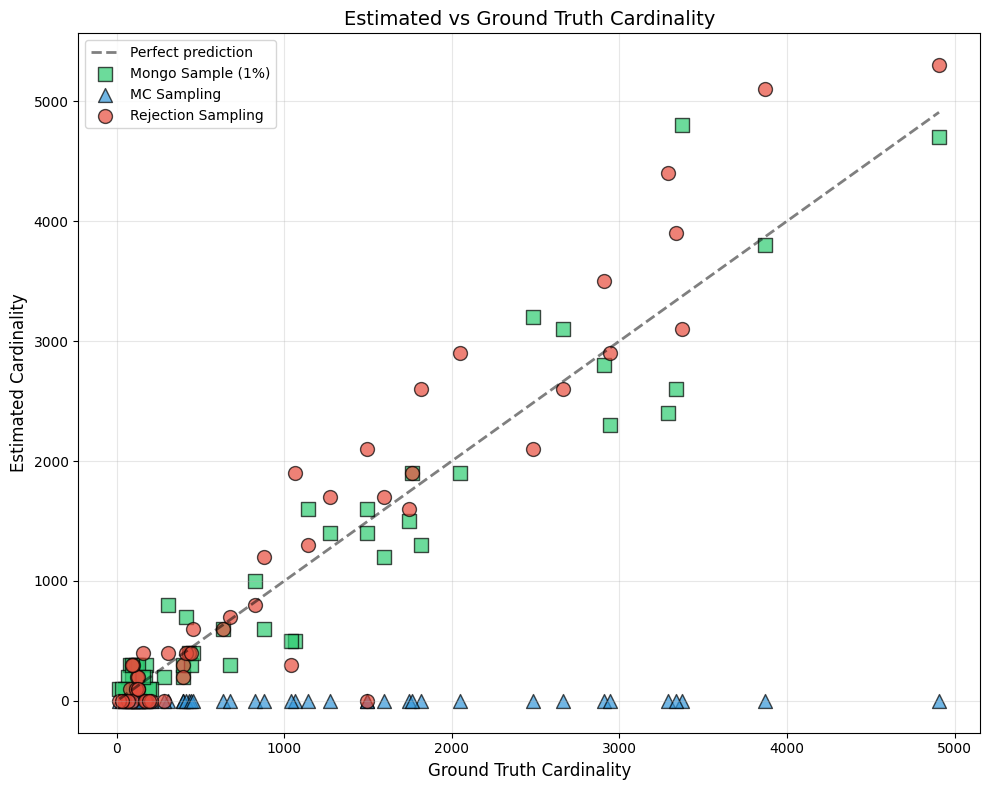

In [ ]:
import matplotlib.pyplot as plt

# Create figure with estimated vs ground truth
plt.figure(figsize=(10, 8))

# Perfect prediction line
min_val = np.min(ground_truth_vals)
max_val = np.max(ground_truth_vals)
plt.plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5, label="Perfect prediction", linewidth=2)

# Plot each estimator with different markers
markers = ["s", "^", "o"]
colors = ["#2ecc71", "#3498db", "#e74c3c"]

for i, (name, est_vals, marker, color) in enumerate(
    zip(estimator_names, [sample_est_vals, mc_est_vals, rej_est_vals], markers, colors)
):
    plt.scatter(
        ground_truth_vals,
        est_vals,
        marker=marker,
        s=100,
        alpha=0.7,
        label=name,
        color=color,
        edgecolors="black",
        linewidths=1,
    )

plt.xlabel("Ground Truth Cardinality", fontsize=12)
plt.ylabel("Estimated Cardinality", fontsize=12)
plt.title("Estimated vs Ground Truth Cardinality", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/cp/r86_5xy15c564s3wsczlqgrc0000gn/T/ipykernel_51767/591976826.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=estimator_names, patch_artist=True, widths=0.6)


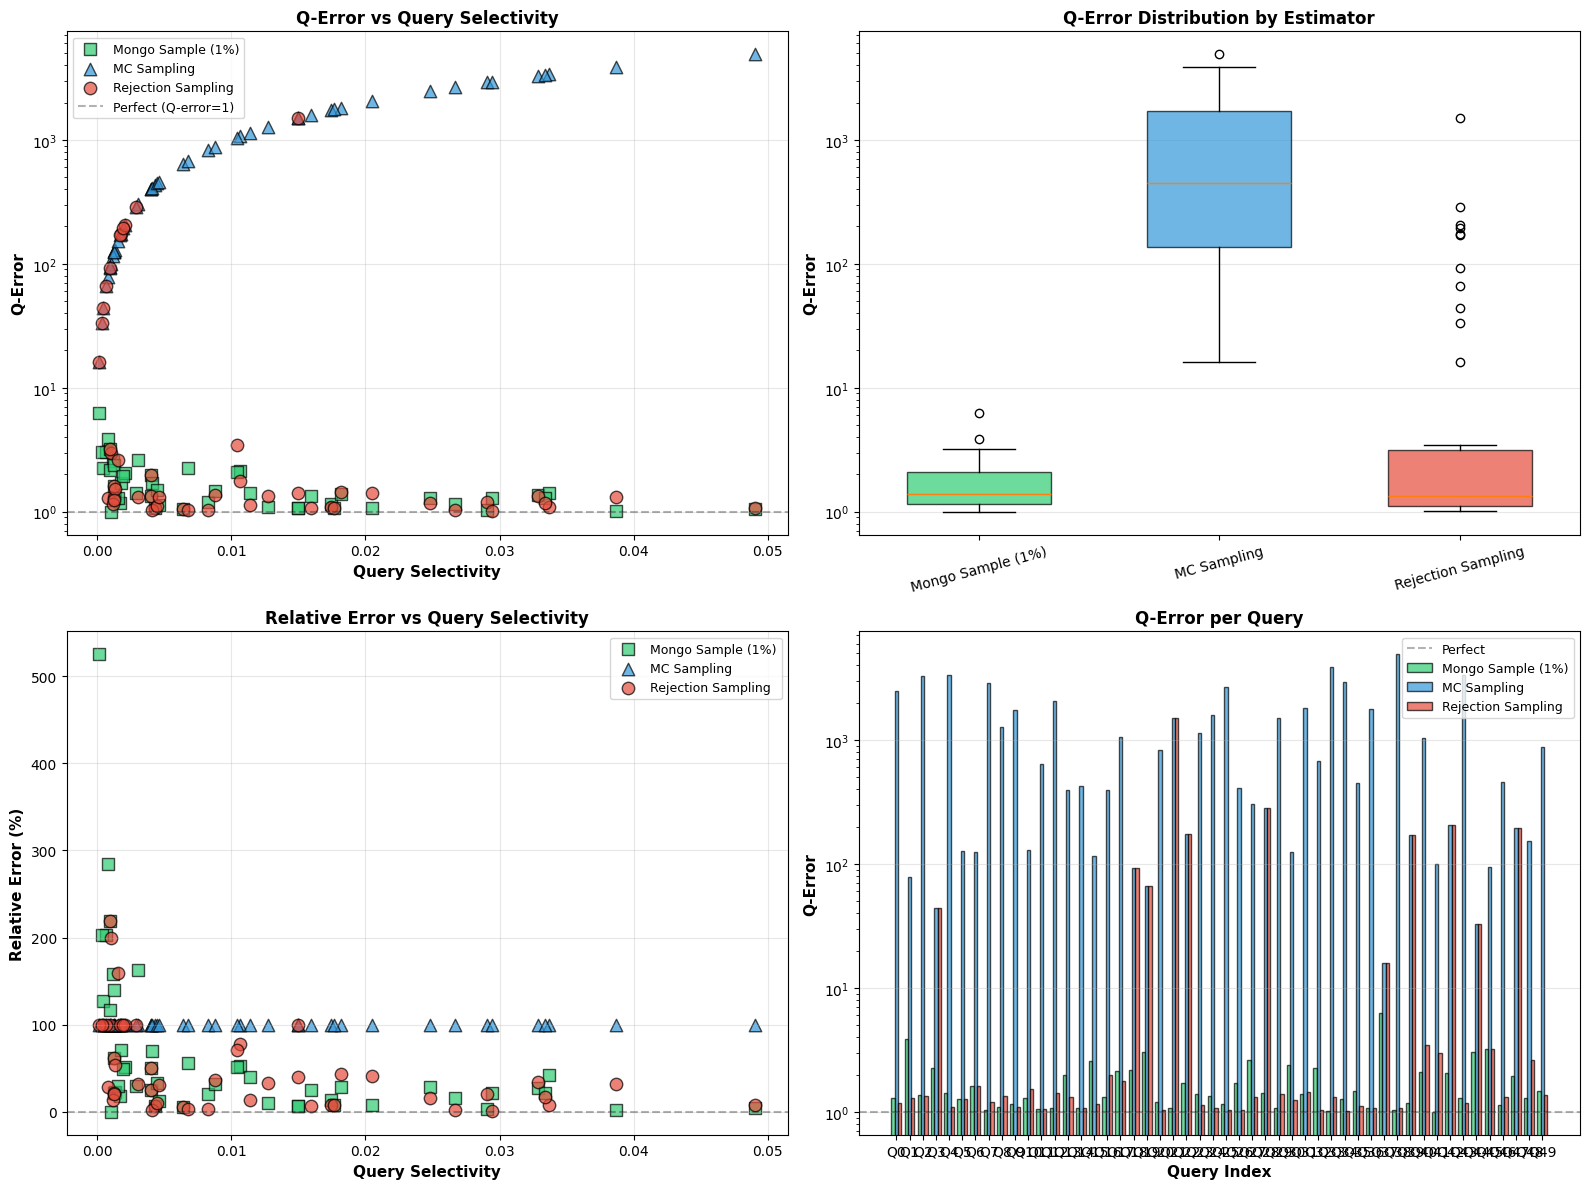

In [ ]:
# Create 2x2 subplot grid for additional analyses
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Q-Error vs Selectivity
ax1 = axes[0, 0]
for name, q_errors, marker, color in zip(estimator_names, q_errors_list, markers, colors):
    ax1.scatter(
        selectivities,
        q_errors,
        marker=marker,
        s=80,
        alpha=0.7,
        label=name,
        color=color,
        edgecolors="black",
        linewidths=1,
    )
ax1.set_xlabel("Query Selectivity", fontsize=11, fontweight="bold")
ax1.set_ylabel("Q-Error", fontsize=11, fontweight="bold")
ax1.set_title("Q-Error vs Query Selectivity", fontsize=12, fontweight="bold")
ax1.axhline(y=1, color="k", linestyle="--", alpha=0.3, label="Perfect (Q-error=1)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

# 2. Q-Error Distribution (Box Plot)
ax2 = axes[0, 1]
box_data = [q_errors_sample, q_errors_mc, q_errors_rej]
bp = ax2.boxplot(box_data, labels=estimator_names, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel("Q-Error", fontsize=11, fontweight="bold")
ax2.set_title("Q-Error Distribution by Estimator", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")
ax2.set_yscale("log")
ax2.tick_params(axis="x", rotation=15)

# 3. Relative Error vs Selectivity
ax3 = axes[1, 0]
for name, est_vals, marker, color in zip(
    estimator_names, [sample_est_vals, mc_est_vals, rej_est_vals], markers, colors
):
    relative_errors = np.abs(est_vals - ground_truth_vals) / ground_truth_vals * 100
    ax3.scatter(
        selectivities,
        relative_errors,
        marker=marker,
        s=80,
        alpha=0.7,
        label=name,
        color=color,
        edgecolors="black",
        linewidths=1,
    )
ax3.set_xlabel("Query Selectivity", fontsize=11, fontweight="bold")
ax3.set_ylabel("Relative Error (%)", fontsize=11, fontweight="bold")
ax3.set_title("Relative Error vs Query Selectivity", fontsize=12, fontweight="bold")
ax3.axhline(y=0, color="k", linestyle="--", alpha=0.3)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Per-Query Q-Error Comparison
ax4 = axes[1, 1]
x = np.arange(len(workload))
width = 0.25

bars1 = ax4.bar(
    x - width,
    q_errors_sample,
    width,
    label=estimator_names[0],
    color=colors[0],
    alpha=0.7,
    edgecolor="black",
    linewidth=1,
)
bars2 = ax4.bar(
    x, q_errors_mc, width, label=estimator_names[1], color=colors[1], alpha=0.7, edgecolor="black", linewidth=1
)
bars3 = ax4.bar(
    x + width, q_errors_rej, width, label=estimator_names[2], color=colors[2], alpha=0.7, edgecolor="black", linewidth=1
)

ax4.set_xlabel("Query Index", fontsize=11, fontweight="bold")
ax4.set_ylabel("Q-Error", fontsize=11, fontweight="bold")
ax4.set_title("Q-Error per Query", fontsize=12, fontweight="bold")
ax4.set_xticks(x)
ax4.set_xticklabels([f"Q{i}" for i in range(len(workload))])
ax4.axhline(y=1, color="k", linestyle="--", alpha=0.3, label="Perfect")
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis="y")
ax4.set_yscale("log")

plt.tight_layout()
plt.show()